In [1]:
import os
import glob
import gzip
import math
import random
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import shapely.wkt as wkt
from shapely.geometry import Point, LineString, box
from shapely.ops import nearest_points
import lxml.etree as ET
import tqdm
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, Subset
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.transforms import LineGraph
import processing_io as pio

districts = gpd.read_file("../../../../data/visualisation/districts_paris.geojson")

path = "../../../../data/pop_1pm_simulations/sample_sim_output/"

eqasim_pt = pd.read_csv(path + "eqasim_pt.csv", sep=";")
eqasim_trips = pd.read_csv(path + "eqasim_trips.csv", sep=";")
output_links = pd.read_csv(path + "output_links.csv", sep=";")
output_trips = pd.read_csv(path + "output_trips.csv", sep=";")


# basecase_subdir = pio.get_subdirs(path + string_is_for_1pm + "_basecase/")
# comparison_subdir = pio.get_subdirs(path + string_is_for_1pm + "_policy_in_zone_2")

# result_path_basecase_mean = "results/gdf_" + string_is_for_1pm + "_basecase_mean.geojson"
# result_path_comparison_mean = "results/gdf_" + string_is_for_1pm + "_policy_in_" + string_district_of_interest + ".geojson"
# result_path_difference = "results/gdf_" + string_is_for_1pm + "_difference.geojson"

In [2]:
eqasim_trips.head()

,person_id,person_trip_id,origin_x,origin_y,destination_x,destination_y,departure_time,travel_time,vehicle_distance,routed_distance,mode,preceding_purpose,following_purpose,returning,euclidean_distance
0,7826870,0,650920.884420,6.863808e+06,655238.176446,6.866969e+06,0.0,815.0,10480.891994,10549.136691,car,work,outside,False,5350.733594
1,5800773,0,655523.682149,6.860831e+06,652740.495115,6.857491e+06,14389.0,560.0,5950.920874,5958.305713,car,work,outside,False,4347.092640
2,10583393,0,643494.978291,6.863251e+06,653170.349957,6.857549e+06,14717.0,861.0,14246.678480,14246.678480,car,outside,outside,False,11230.555749
3,10583393,1,653170.349957,6.857549e+06,653412.473013,6.857613e+06,15578.0,0.0,0.000000,250.437965,outside,outside,outside,False,250.437965
4,198751,0,649511.669695,6.859818e+06,647125.109579,6.861556e+06,13743.0,1843.0,3393.799120,4209.407269,pt,home,work,False,2952.550515


In [3]:
eqasim_trips['routed_distance'].sum()

52277676.1296989

In [11]:
output_trips.columns

Index(['person', 'trip_number', 'trip_id', 'dep_time', 'trav_time',
       'wait_time', 'traveled_distance', 'euclidean_distance', 'main_mode',
       'longest_distance_mode', 'modes', 'start_activity_type',
       'end_activity_type', 'start_facility_id', 'start_link', 'start_x',
       'start_y', 'end_facility_id', 'end_link', 'end_x', 'end_y',
       'first_pt_boarding_stop', 'last_pt_egress_stop'],
      dtype='object')

In [4]:
output_trips.head()

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,start_facility_id,start_link,start_x,start_y,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop
0,10012156,1,10012156_1,08:48:30,00:34:06,00:00:00,9214,6716,pt,pt,...,outside_1,339663,654302.838874,6.858944e+06,work_2113924,339056,648229.900000,6.861812e+06,NaN,NaN
1,10012156,2,10012156_2,17:24:13,00:50:04,00:00:00,3605,2773,walk,walk,...,work_2113924,339056,648229.900000,6.861812e+06,outside_2,57412,647493.161680,6.859138e+06,NaN,NaN
2,10012156,3,10012156_3,18:14:17,00:00:01,00:00:00,1467,1467,outside,outside,...,outside_2,57412,647493.161680,6.859138e+06,outside_3,592968,646446.652587,6.860166e+06,NaN,NaN
3,10012156,4,10012156_4,18:18:00,00:42:15,00:00:00,9623,7950,pt,pt,...,outside_3,592968,646446.652587,6.860166e+06,outside_1,339663,654302.838874,6.858944e+06,NaN,NaN
4,10012879,1,10012879_1,08:54:43,00:14:58,00:00:00,16457,9966,car,car,...,outside_4,332461,655400.099916,6.858685e+06,outside_5,46724,648720.242119,6.866081e+06,NaN,NaN


In [5]:
output_trips['traveled_distance'].sum()

52730231

In [7]:
eqasim_trips_groupby = eqasim_trips.groupby('mode')['routed_distance'].sum()

In [13]:
output_trips.groupby('longest_distance_mode')['traveled_distance'].sum()

longest_distance_mode
bike              1389818
car              18444005
car_passenger     4074728
outside           2916240
pt               21844744
walk              4060696
Name: traveled_distance, dtype: int64

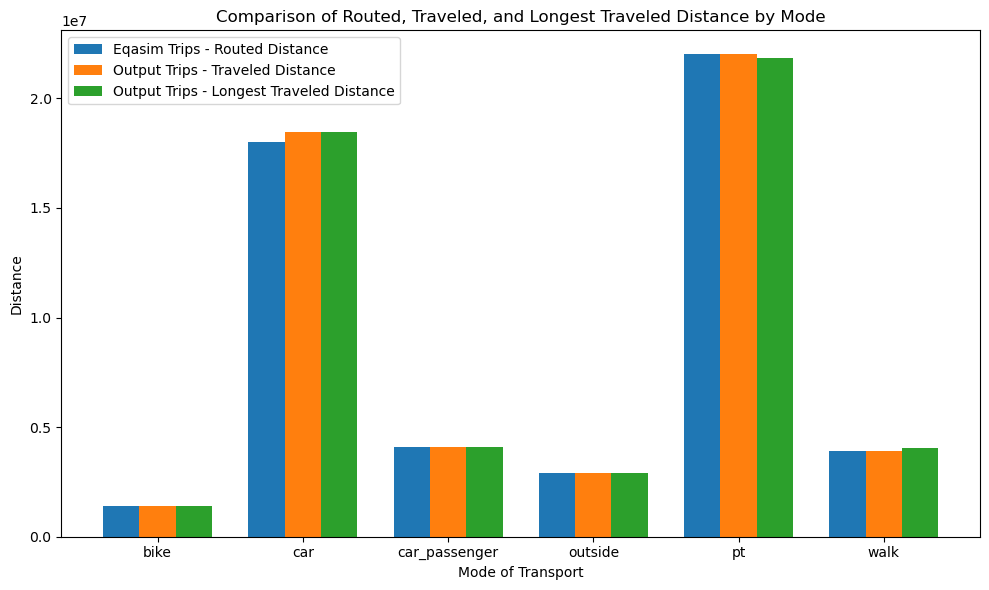

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

eqasim_trips_groupby = {
    'mode': ['bike', 'car', 'car_passenger', 'outside', 'pt', 'walk'],
    'routed_distance': [1.389817e+06, 1.799725e+07, 4.076165e+06, 2.916280e+06, 2.199990e+07, 3.898260e+06]
}

output_trips_groupby = {
    'main_mode': ['bike', 'car', 'car_passenger', 'outside', 'pt', 'walk'],
    'traveled_distance': [1389818, 18449795, 4076176, 2916240, 21999925, 3898277]
}

output_trips_longest_distance_groupby = {
    'longest_distance_mode': ['bike', 'car', 'car_passenger', 'outside', 'pt', 'walk'],
    'longest_distance': [1389818, 18444005, 4074728, 2916240, 21844744, 4060696]
}

# Convert to DataFrames
eqasim_trips_df = pd.DataFrame(eqasim_trips_groupby)
output_trips_df = pd.DataFrame(output_trips_groupby)
output_trips_ld = pd.DataFrame(output_trips_longest_distance_groupby)

# Merging DataFrames for easier plotting
merged_df = pd.merge(eqasim_trips_df, output_trips_df, left_on='mode', right_on='main_mode')

# Convert to DataFrames
eqasim_trips_df = pd.DataFrame(eqasim_trips_groupby)
output_trips_df = pd.DataFrame(output_trips_groupby)
output_trips_ld_df = pd.DataFrame(output_trips_longest_distance_groupby)

# Merging DataFrames for easier plotting
merged_df = pd.merge(eqasim_trips_df, output_trips_df, left_on='mode', right_on='main_mode')
merged_df = pd.merge(merged_df, output_trips_ld_df, left_on='mode', right_on='longest_distance_mode')

# Plotting the distances
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = range(len(merged_df))

ax.bar(index, merged_df['routed_distance'], bar_width, label='Eqasim Trips - Routed Distance')
ax.bar([i + bar_width for i in index], merged_df['traveled_distance'], bar_width, label='Output Trips - Traveled Distance')
ax.bar([i + 2 * bar_width for i in index], merged_df['longest_distance'], bar_width, label='Output Trips - Longest Traveled Distance')

# Labels, title, legend
ax.set_xlabel('Mode of Transport')
ax.set_ylabel('Distance')
ax.set_title('Comparison of Routed, Traveled, and Longest Traveled Distance by Mode')
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(merged_df['mode'])
ax.legend()

plt.tight_layout()
plt.show()